In [1]:
import requests
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import itertools
import functools
import json
from sklearn.cluster import KMeans
pp = pprint.PrettyPrinter(indent=4)
plt.rcParams['figure.figsize'] = [10, 6]


## Pipeline
Inputs: gameweek, gameweeks to roll
1. Fetch fixtures for each team for the relevant gameweeks

Output: map of lists containing tuples: (<home/away>, </opponent team id>) 
2. Map to difficulty of each fixtures

Output: map of lists containing tuples: (</opponent team id>, </offensive difficulty>, </defensive difficulty>)
3. Sum difficulties for both offensive and defensive difficulty over gws

Output: map of tuples: (</sum of offensive difficulty>, </sum of defensive difficulty>)

In [2]:
def fetch_fixtures_for_gws_considered(raw_gw_fixtures, starting_gw, gws_to_roll):
    fixtures_per_team = dict()
    for i in range(1, 21):
        def filter_function(element):
            if element["event"] == None:
                return False
            return element["event"] >= starting_gw and element["event"] < starting_gw + gws_to_roll and (element["team_h"] == i or element["team_a"] == i) 
        fixtures_over_period_considered = list(filter(filter_function, raw_gw_fixtures))
        def map_function(element):
            home = True
            if element["team_a"] == i:
                home = False
            return (home, element["team_a"] if home else element["team_h"])
        fixtures_over_period_considered = list(map(map_function, fixtures_over_period_considered))
        fixtures_per_team[i] = fixtures_over_period_considered
    return fixtures_per_team

In [3]:
def fetch_fpl_based_team_strength(club_metadata):
    team_strength = dict()

    for i, team_id in enumerate(club_metadata["id"]):
        team_strength[team_id] = dict()
        team_strength[team_id]["home"] = {
            "attack": club_metadata["strength_attack_home"][i],
            "defense": club_metadata["strength_defence_home"][i]
        }
        team_strength[team_id]["away"] = {
            "attack": club_metadata["strength_attack_away"][i],
            "defense": club_metadata["strength_defence_away"][i]
        }
    return team_strength


In [4]:
def fetch_xg_based_team_strength():
    cleaned_team_strength = dict()
    with open("xg_diff_team_strength") as f:
        team_strength = json.loads(f.read())
    for k, v in team_strength.items():
        cleaned_team_strength[int(k)] = v
    return cleaned_team_strength

In [5]:
def map_fixture_difficulty(gw_fixtures, team_strength):
    gw_fixture_difficulty = dict()
    for team_id in gw_fixtures.keys():
        def mapping_function(element):
            location = "home" if element[0] else "away"
            opposition_team_id = element[1]
            attack_strength = team_strength[opposition_team_id][location]["attack"]
            defense_strength = team_strength[opposition_team_id][location]["defense"]
            return (attack_strength, defense_strength)
        gw_fixture_difficulty[team_id] = list(map(mapping_function, gw_fixtures[team_id]))
    return gw_fixture_difficulty

In [6]:
def aggregate_difficulty(gw_fixture_difficulty, gws_to_roll, max_fixture_difficulty):
    agg_gw_fixture_difficulty = dict()
    def attack_reduce_func(element_a, element_b):
        return (element_a[0] + element_b[0], 0)
    def defense_reduce_func(element_a, element_b):
        return (0, element_a[1] + element_b[1])
    for team_id, fixture_difficulty_list in gw_fixture_difficulty.items():
        raw_fixture_length = len(fixture_difficulty_list)
        # for gameweeks where a fixture isn't played assume the hardest difficulty 
        while len(fixture_difficulty_list) < gws_to_roll:
            fixture_difficulty_list.append((max_fixture_difficulty, max_fixture_difficulty))
        agg_attack_strength = functools.reduce(attack_reduce_func, fixture_difficulty_list)
        agg_defense_strength = functools.reduce(defense_reduce_func, fixture_difficulty_list)
        agg_gw_fixture_difficulty[team_id] = (agg_attack_strength[0], agg_defense_strength[1], raw_fixture_length)
    return agg_gw_fixture_difficulty

In [7]:
def prettify_results(aggregate_fixture_difficulty, club_metadata):
    df = pd.DataFrame(columns=["team_name", "team_id", "num_fixtures", "opposition_aggregate_attack_strength", "opposition_aggregate_defense_strength"])
    for team_id, aggregate_fixture_difficulty in aggregate_fixture_difficulty.items():
        item = {
            "team_name": convert_id_to_team_name(team_id, club_metadata),
            "team_id": team_id,
            "opposition_aggregate_attack_strength": aggregate_fixture_difficulty[0],
            "opposition_aggregate_defense_strength": aggregate_fixture_difficulty[1],
            "num_fixtures": aggregate_fixture_difficulty[2]
        }
        df = df.append(item, ignore_index=True)
    df = df.set_index("team_id")
    return df


In [8]:
def convert_id_to_team_name(team_id, club_metadata):
    return club_metadata[club_metadata.id == team_id].name.iloc[0]

In [9]:
def inspect_fixtures_for_team(team_id, gw_fixtures, club_metadata):
    print("Fixtures for {}:".format(convert_id_to_team_name(team_id, club_metadata)))
    fixtures = gw_fixtures[team_id]
    for f in fixtures:
        print("{} against {}\n".format("home" if f[0] else "away", convert_id_to_team_name(f[1], club_metadata)))

In [10]:
def min_from_team_opportunity(item):
    elements = list(item[1]["home"].values()) + list(item[1]["away"].values())
    return min(elements)


In [11]:
def team_strength_to_df(team_strength, club_metadata):
    team_strength_df = pd.DataFrame(columns=["team_name", "attack_home", "defense_home", "attack_away", "defense_away"])
    for team_id, element in team_strength.items():
        item = {
            "team_name": convert_id_to_team_name(team_id, club_metadata),
            "attack_home": element["home"]["attack"],
            "defense_home": element["home"]["defense"],
            "attack_away": element["away"]["attack"],
            "defense_away": element["away"]["defense"]
        }
        team_strength_df = team_strength_df.append(item, ignore_index=True)
        
    return team_strength_df

In [33]:
def plot_results_as_bar_chart_with_clustering(results, column):
    num_clusters = 4
    colors = ['red', 'orange', 'lightgreen', 'green']
    sorted_results = results.sort_values(column)
    reshaped_results = np.reshape(sorted_results[column].values, (-1, 1))
    k_means_results = KMeans(n_clusters=num_clusters).fit(reshaped_results)
    centres = [np.round(item[0], 2) for item in k_means_results.cluster_centers_]
    sorted_centres = np.sort(centres)
    def where_does_x_appear_in_l(x, l):
        for i, y in enumerate(l):
            if x == y:
                return i
    centres_ranks = [where_does_x_appear_in_l(x, sorted_centres) for x in centres]
    k_means_colors = list(map(lambda r: colors[centres_ranks[r]], k_means_results.labels_))
    plt.bar(sorted_results.team_name, sorted_results[column], color=k_means_colors)
    plt.xticks(rotation=90)
    plt.show()

In [34]:
raw_gw_fixtures = requests.get('https://fantasy.premierleague.com/api/fixtures').json()
club_metadata = pd.DataFrame(requests.get("https://fantasy.premierleague.com/api/bootstrap-static/").json()["teams"])

In [53]:
starting_gw = 22
gws_to_roll = 6


In [54]:
print("Analysing gameweeks from gw {} to {} inclusive".format(starting_gw, starting_gw + gws_to_roll - 1))

Analysing gameweeks from gw 22 to 27 inclusive


In [55]:
gw_fixtures = fetch_fixtures_for_gws_considered(raw_gw_fixtures, starting_gw, gws_to_roll)
# team_strength = fetch_fpl_based_team_strength(club_metadata)
team_strength = fetch_xg_based_team_strength()
min_team_opportunity = min(list(map(min_from_team_opportunity, list(team_strength.items()))))
gw_fixture_difficulty = map_fixture_difficulty(gw_fixtures, team_strength)
aggregate_fixture_difficulty = aggregate_difficulty(gw_fixture_difficulty, gws_to_roll, min_team_opportunity)
results = prettify_results(aggregate_fixture_difficulty, club_metadata)


In [56]:
results

,team_name,num_fixtures,opposition_aggregate_attack_strength,opposition_aggregate_defense_strength
team_id,,,,
1,Arsenal,4,2.60,2.35
2,Aston Villa,6,3.18,3.62
3,Brentford,7,3.25,3.22
4,Brighton,6,3.42,3.61
5,Burnley,6,2.42,2.85
6,Chelsea,4,1.83,1.59
7,Crystal Palace,6,2.86,2.89
8,Everton,6,3.28,3.18
9,Leicester,5,2.58,2.17


Opposition defense strength - used for picking mids and fws

In [57]:

# green yellow blue yellow orange

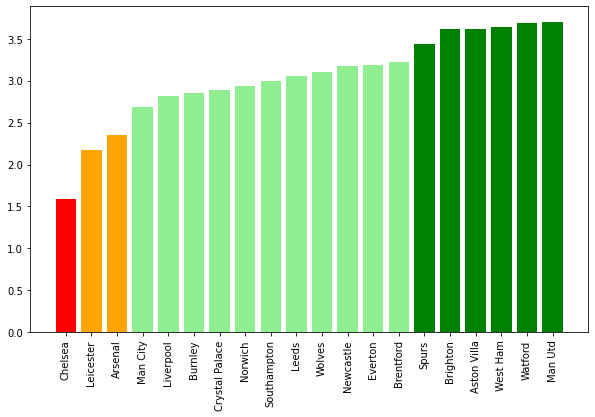

In [58]:
plot_results_as_bar_chart_with_clustering(results, "opposition_aggregate_defense_strength")


Opposition attack strength - used for picking dfs and gks

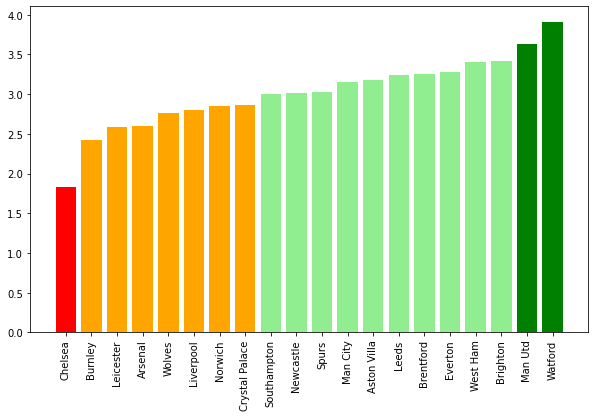

In [59]:
plot_results_as_bar_chart_with_clustering(results, "opposition_aggregate_attack_strength")


Data deeper dive

In [60]:
inspect_fixtures_for_team(3, gw_fixtures, club_metadata)

Fixtures for Brentford:
away against Liverpool

home against Man Utd

home against Wolves

away against Man City

home against Crystal Palace

away against Arsenal

home against Newcastle



In [54]:
team_strength_to_df(fetch_xg_based_team_strength(), club_metadata).sort_values("attack_away", ascending=False)

,team_name,attack_home,defense_home,attack_away,defense_away
14,Norwich,0.71,0.78,0.65,0.56
19,Wolves,0.63,0.50,0.64,0.45
17,Watford,0.53,0.66,0.64,0.80
1,Aston Villa,0.60,0.55,0.63,0.51
13,Newcastle,0.76,0.67,0.60,0.67
15,Southampton,0.56,0.63,0.53,0.40
4,Burnley,0.70,0.69,0.51,0.42
2,Brentford,0.62,0.50,0.50,0.41
3,Brighton,0.65,0.44,0.47,0.44
7,Everton,0.59,0.60,0.45,0.52


## Plot rolling difficulty for a given side

In [495]:
gw_fixtures = fetch_fixtures_for_gws_considered(raw_gw_fixtures, starting_gw, 38)
# team_strength = fetch_fpl_based_team_strength(club_metadata)
team_strength = fetch_xg_based_team_strength()
max_team_strength = max(list(map(max_from_team_strength, list(team_strength.items()))))
gw_fixture_difficulty = map_fixture_difficulty(gw_fixtures, team_strength)



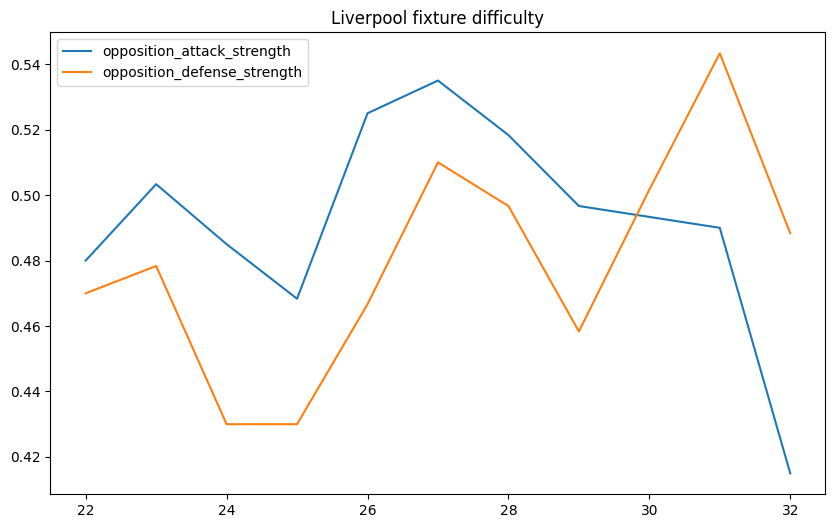

In [499]:
team_id_considered = 11
gw_fixture_difficulty_considered = gw_fixture_difficulty[team_id_considered]
opposition_attack_strength = pd.Series(map(lambda item: item[0], gw_fixture_difficulty_considered)).rolling(gws_to_roll).mean().dropna()
opposition_defense_strength = pd.Series(map(lambda item: item[1], gw_fixture_difficulty_considered)).rolling(gws_to_roll).mean().dropna()
x = [i for i in range(starting_gw, starting_gw + len(opposition_attack_strength))]
plt.plot(x, opposition_attack_strength, label="opposition_attack_strength")
plt.plot(x, opposition_defense_strength, label="opposition_defense_strength")
plt.title("{} fixture difficulty".format(convert_id_to_team_name(team_id_considered, club_metadata)))
plt.legend()
plt.show()
